##Preprocessing

In [ ]:
#Interruption Preventing
%%javascript
function ClickConnect(){
    console.log("Working");
    document
        .querySelector("#top-toolbar > colab-connect-button")
        .shadowRoot
        .querySelector("#connect")
        .click()
}

setInterval(ClickConnect,60000)

<IPython.core.display.Javascript object>

In [ ]:
#Imports
import os
import random
import requests
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import itertools
from time import time
from glob import glob
from statistics import mean
from tensorflow import keras
from tensorflow.keras import layers, optimizers
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Activation, Dropout, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras import backend as K
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from matplotlib.ticker import PercentFormatter

In [ ]:
#Link To Google Drive
from google.colab import drive, files
drive.mount("/content/drive")

Mounted at /content/drive


##Functions Setting

In [ ]:
#Getting Confusion Matrix
def conf_matrix_and_prob(model, data_dir, test_gen, treshold):
    predictions =[]
    true_y = []
    predictprob = np.zeros([test_gen.samples, len(test_gen.class_indices) if len(test_gen.class_indices)>2 else 1])

    for ix, (x, y) in enumerate(test_gen): 
      predictprob[ix,:] = model.predict(x)

      if len(test_gen.class_indices)>2:
        prediction = np.argmax(model.predict(x), axis=1)
        y = np.argmax(y, axis =1)
        
      else:
        prediction = [1 if model.predict(x) > treshold else 0]    
        
      predictions = np.concatenate((predictions, prediction))          
      true_y = np.concatenate((true_y, y))
      
      if len(predictions) >= test_gen.samples:
          break

    matrix = confusion_matrix(true_y, predictions)

    return matrix, predictprob

In [ ]:
#Calculating N-classes Confusion Matrix
def calculate_metrics(confusion_matrix):
  if len(confusion_matrix)>2:
    classes = len(confusion_matrix)
    tps = []
    fps = []
    fns = []
    tns = []
    
    for i in range(classes):
      tps.append(confusion_matrix[i][i])
      fp = 0
      fn = 0
      tn = 0
      for j in range(classes):
        if j != i:
          fp += confusion_matrix[j][i]
          fn += confusion_matrix[i][j]
          for k in range(classes):
            if k != i:
              tn += confusion_matrix[j][k]
      fps.append(fp)
      fns.append(fn)
      tns.append(tn)

    accuracy = []
    recall = []
    precision = []
    f1_score = []
    
    for i in range(classes):
      tp = tps[i]
      fp = fps[i]
      fn = fns[i]
      tn = tns[i]
      acc = (tp + tn) / (tp + fn + fp + tn)
      rec = tp / (tp + fn)
      pre = tp / (tp + fp)
      f1 = 2 * pre * rec / (pre + rec)
      accuracy.append(acc)
      recall.append(rec)
      precision.append(pre)
      f1_score.append(f1)
  
  else:
    tp = confusion_matrix[1][1]
    fn = confusion_matrix[1][0] 
    fp = confusion_matrix[0][1] 
    tn = confusion_matrix[0][0] 

    accuracy = (tp + tn) / (tp + fn + fp + tn)
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    f1_score = 2 * precision * recall / (precision + recall)
  
  return accuracy, recall, precision, f1_score

In [ ]:
#Ploting Confusion Matrix
def PlotConfusionMatrix(cm, classes, normalize = False, title = 'Confusion matrix', cmap = plt.cm.Blues):
   
    #Normalization can be applied by setting `normalize = True`
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)
    acc, rec, pre, f1_s = calculate_metrics(cm)
    if len(classes) == 2:
      print(f'Accuracy: {acc:.3f}\nRecall: {rec:.3f}\nPrecision: {pre:.3f}\nF1 score: {f1_s:.3f}')
    else:
      print(f'Accuracy: {mean(acc):.3f}\nRecall: {mean(rec):.3f}\nPrecision: {mean(pre):.3f}\nF1 score: {mean(f1_s):.3f}')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [ ]:
#LINE Notify
def LineNotify(token, msg = '', img_dir = ''):
    #HTTP 標頭參數與資料
    headers = {"Authorization": "Bearer " + token} #token = API token of LINE Notify
    data = {'message': '\n' + msg}  # 要發送的訊息
    files = { 'imageFile': open(img_dir, 'rb') if img_dir else None} # 要傳送的圖片檔案
    #以 requests 發送 POST 請求
    requests.post("https://notify-api.line.me/api/notify", headers = headers, data = data, files = files)

In [ ]:
#Converting sec to hr/min/sec
def time_convertion_string(s):
  string = ''
  if s//3600:
    string += f'{s//3600:2.0f} hr '
    s%=3600
  if s//60:
    string += f'{s//60:2.0f} min '
    s%=60
  string += f'{s:2.0f} sec'
  return string

time_convertion_string(12345.6789)

' 3 hr 25 min 46 sec'

##Model Setting

In [ ]:
#Variables Setting
tok = '(Replace this string with Ur API token of LINE Notify)' #LINE Notify API token
trshld = .3
tester = '莊孝穎'

In [ ]:
#Getting Model Directions
models_dir = '/content/drive/MyDrive/chest_xray/ModelsToEnsembleBV'
model_dirs = glob(models_dir + '/*.h5')
#model_dirs = [m for m in model_dirs if not os.path.exists(m.split('.')[:-1][0] + '.jpg')]
model_names = [x.split('/')[-1] for x in model_dirs]
for model_dir in model_dirs:
  if '(' in model_dir:
    print('There seems to exist a same model already. ({})'.format(model_dir.split('/')[-1].split('(')[0]))
    #os.remove(model_dir)
    #model_dirs.remove(model_dir)
model_names

['ChestX-Ray2BV_23141627_acc92_rec89_prec89.h5',
 'ChestX-Ray2BV_23142227_acc91_rec83_prec93.h5',
 'ChestX-Ray2BV_23152139_acc90_rec85_prec88.h5',
 'ChestX-Ray2BV_23161132_acc88_rec77_prec91.h5']

In [ ]:
#Loading Models & Checking Characteristics of Models
models = []
model_characteristics = []

for model_dir in model_dirs:
  models.append(load_model(model_dir)) 
  if 'ChestX-Ray2_' in model_dir:
    model_characteristics.append('NP')
  elif 'ChestX-Ray2BV_' in model_dir:
    model_characteristics.append('BV')
  elif 'ChestX-Ray2NB_' in model_dir:
    model_characteristics.append('NB')
  elif 'ChestX-Ray2NV_' in model_dir:
    model_characteristics.append('NV')
  elif 'ChestX-Ray3_' in model_dir:
    model_characteristics.append('NBV')

model_characteristics

['BV', 'BV', 'BV', 'BV']

In [ ]:
#Unzipping
if 'NP' in model_characteristics:
  !unzip /content/drive/MyDrive/chest_xray/chest_xray2.zip -d /content/ #2分類NP
if 'BV' in model_characteristics:
  !unzip /content/drive/MyDrive/chest_xray/BV.zip -d /content/ #2分類BV
if 'NB' in model_characteristics:
  !unzip /content/drive/MyDrive/chest_xray/NB.zip -d /content/ #2分類NB
if 'NV' in model_characteristics:
  !unzip /content/drive/MyDrive/chest_xray/NV.zip -d /content/ #2分類NV
if 'NBV' in model_characteristics:
  !unzip /content/drive/MyDrive/chest_xray/chest_xray3.zip -d /content/ #3分類NBV

Archive:  /content/drive/MyDrive/chest_xray/BV.zip
   creating: /content/BV/
   creating: /content/BV/test/
   creating: /content/BV/test/BACTERIA/
  inflating: /content/BV/test/BACTERIA/desktop.ini  
  inflating: /content/BV/test/BACTERIA/person100_bacteria_475.jpeg  
  inflating: /content/BV/test/BACTERIA/person100_bacteria_477.jpeg  
  inflating: /content/BV/test/BACTERIA/person100_bacteria_478.jpeg  
  inflating: /content/BV/test/BACTERIA/person100_bacteria_479.jpeg  
  inflating: /content/BV/test/BACTERIA/person100_bacteria_480.jpeg  
  inflating: /content/BV/test/BACTERIA/person100_bacteria_481.jpeg  
  inflating: /content/BV/test/BACTERIA/person100_bacteria_482.jpeg  
  inflating: /content/BV/test/BACTERIA/person101_bacteria_483.jpeg  
  inflating: /content/BV/test/BACTERIA/person101_bacteria_484.jpeg  
  inflating: /content/BV/test/BACTERIA/person101_bacteria_485.jpeg  
  inflating: /content/BV/test/BACTERIA/person101_bacteria_486.jpeg  
  inflating: /content/BV/test/BACTERIA/p

In [ ]:
#Directions Setting
tst_dirs = []
for model_characteristic in model_characteristics:
  if model_characteristic == 'NP' or model_characteristic == 'NBV':
    tst_dirs.append('/content/chest_xray/test')
  elif model_characteristic in ['BV','NB','NV']:
    tst_dirs.append('/content/' + model_characteristic + '/test')
  else:
    raise ValueError('Unknown tst_dir!')

tst_dirs

['/content/BV/test',
 '/content/BV/test',
 '/content/BV/test',
 '/content/BV/test']

In [ ]:
#Testgenerators Setting
testgenerators = []
for idx, model in enumerate(models):
  if model.input.name == 'inception_v3_input':
    preprocessing_funct = tf.keras.applications.inception_v3.preprocess_input

  elif 'conv2d' in model.input.name or model.input.name == 'efficientnetv2-s_input':
    preprocessing_funct = None

  elif model.input.name == 'efficientnet_v2_input':
    preprocessing_funct = tf.keras.applications.efficientnet_v2.preprocess_input

  elif model.input.name == 'resnet_input':
    preprocessing_funct = tf.keras.applications.resnet.preprocess_input

  elif model.input.name == 'resnet152v2_input' or model.input.name == 'resnet50v2_input':
    preprocessing_funct = tf.keras.applications.resnet_v2.preprocess_input

  elif model.input.name == 'xception_input':
    preprocessing_funct = tf.keras.applications.xception.preprocess_input
  
  elif model.input.name == 'mobilenet_1.00_224_input':
    preprocessing_function= tf.keras.applications.mobilenet.preprocess_input

  else:
    print(f'What\'s "{model.input.name}"? (idx = {models.index(model)})')
    raise NameError('Unknown Model!')

  print(f'【{model_names[idx]}】 input.name = {model.input.name}\n')
  testgenerators.append(ImageDataGenerator(rescale = 1./255, preprocessing_function = preprocessing_funct))

testgenerators

【ChestX-Ray2BV_23141627_acc92_rec89_prec89.h5】 input.name = conv2d_3_input

【ChestX-Ray2BV_23142227_acc91_rec83_prec93.h5】 input.name = resnet152v2_input

【ChestX-Ray2BV_23152139_acc90_rec85_prec88.h5】 input.name = resnet50v2_input

【ChestX-Ray2BV_23161132_acc88_rec77_prec91.h5】 input.name = mobilenet_1.00_224_input



In [ ]:
#Tst_gens Setting
tst_gens = []
labels = []
for idx, (testgenerator, model, tst_dir) in enumerate(zip(testgenerators, models, tst_dirs)):
  print(f'【{model_names[idx]}】')
  target_size = list(model.input_shape)[1:3]
  tst_gen  = testgenerator.flow_from_directory(tst_dir,
                          target_size = target_size,                                          
                          batch_size = 1,
                          shuffle = False,
                          class_mode = "categorical" if len(glob(tst_dir+'/*')) > 2 else 'binary'
                        )
  print(f'class mode = {tst_gen.class_mode}\ntarget_size = {target_size}\nclasses = {tst_gen.class_indices}\n')
  tst_gens.append(tst_gen)
  labels.append([i[0] for i in list(tst_gen.class_indices.items())])

labels

【ChestX-Ray2BV_23141627_acc92_rec89_prec89.h5】
Found 390 images belonging to 2 classes.
class mode = binary
target_size = [256, 256]
classes = {'BACTERIA': 0, 'VIRUS': 1}

【ChestX-Ray2BV_23142227_acc91_rec83_prec93.h5】
Found 390 images belonging to 2 classes.
class mode = binary
target_size = [224, 224]
classes = {'BACTERIA': 0, 'VIRUS': 1}

【ChestX-Ray2BV_23152139_acc90_rec85_prec88.h5】
Found 390 images belonging to 2 classes.
class mode = binary
target_size = [224, 224]
classes = {'BACTERIA': 0, 'VIRUS': 1}

【ChestX-Ray2BV_23161132_acc88_rec77_prec91.h5】
Found 390 images belonging to 2 classes.
class mode = binary
target_size = [224, 224]
classes = {'BACTERIA': 0, 'VIRUS': 1}



[['BACTERIA', 'VIRUS'],
 ['BACTERIA', 'VIRUS'],
 ['BACTERIA', 'VIRUS'],
 ['BACTERIA', 'VIRUS']]

In [ ]:
#Testing 
test_results = []
for idx, (model, tst_gen) in enumerate(zip(models, tst_gens)):
  print(f'\n{model_names[idx]} Testing...')
  test_result = model.evaluate(tst_gen)
  if sum(1 for x in test_result[1:] if x<0.5):
    raise ValueError(f'Theres something wrong with {model_names[idx]}...')
  else:
    test_results.append(test_result)

test_results


ChestX-Ray2BV_23141627_acc92_rec89_prec89.h5 Testing...
390/390 [==============================] - 12s 10ms/step - loss: 0.3192 - accuracy: 0.9231 - recall_1: 0.8986 - precision_1: 0.8986

ChestX-Ray2BV_23142227_acc91_rec83_prec93.h5 Testing...
390/390 [==============================] - 15s 30ms/step - loss: 0.2632 - accuracy: 0.9077 - recall: 0.8041 - precision: 0.9444

ChestX-Ray2BV_23152139_acc90_rec85_prec88.h5 Testing...
390/390 [==============================] - 7s 15ms/step - loss: 0.4644 - accuracy: 0.8179 - recall: 0.8243 - precision: 0.7305

ChestX-Ray2BV_23161132_acc88_rec77_prec91.h5 Testing...
390/390 [==============================] - 5s 10ms/step - loss: 0.3171 - accuracy: 0.8872 - recall: 0.7703 - precision: 0.9194


[[0.31916800141334534,
  0.9230769276618958,
  0.8986486196517944,
  0.8986486196517944],
 [0.2632215917110443,
  0.9076923131942749,
  0.8040540814399719,
  0.9444444179534912],
 [0.4644032120704651,
  0.8179486989974976,
  0.8243243098258972,
  0.7305389046669006],
 [0.31713876128196716,
  0.8871794939041138,
  0.7702702879905701,
  0.9193548560142517]]

In [ ]:
#Getting Cofusion Matrix
cms = []
for model, tst_gen, tst_dir in zip(models, tst_gens, tst_dirs):
  cm, _ = conf_matrix_and_prob(model, tst_dir, tst_gen, trshld)
  cms.append(cm)

cms

1/1 [==============================] - 0s 26ms/step


[array([[186,  56],
        [ 11, 137]]), array([[226,  16],
        [ 19, 129]]), array([[125, 117],
        [  8, 140]]), array([[229,  13],
        [ 20, 128]])]


【model 1 : ChestX-Ray2BV_23141627_acc92_rec89_prec89.h5】
Confusion matrix, without normalization
Accuracy: 0.828
Recall: 0.926
Precision: 0.710
F1 score: 0.804


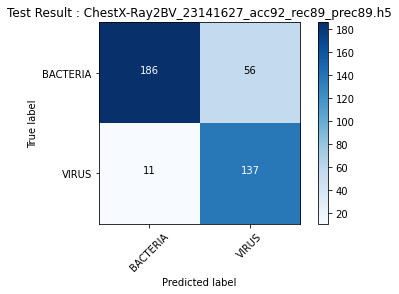


【model 2 : ChestX-Ray2BV_23142227_acc91_rec83_prec93.h5】
Confusion matrix, without normalization
Accuracy: 0.910
Recall: 0.872
Precision: 0.890
F1 score: 0.881


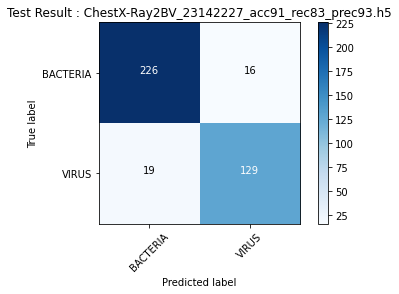


【model 3 : ChestX-Ray2BV_23152139_acc90_rec85_prec88.h5】
Confusion matrix, without normalization
Accuracy: 0.679
Recall: 0.946
Precision: 0.545
F1 score: 0.691


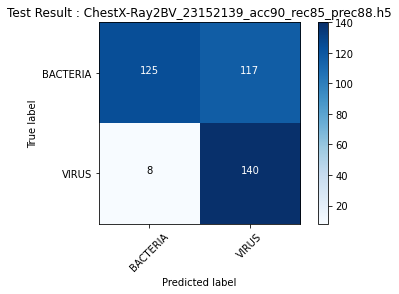


【model 4 : ChestX-Ray2BV_23161132_acc88_rec77_prec91.h5】
Confusion matrix, without normalization
Accuracy: 0.915
Recall: 0.865
Precision: 0.908
F1 score: 0.886


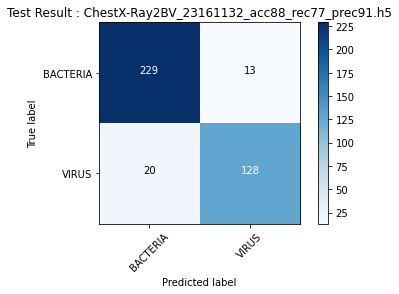

In [ ]:
#Ploting Confusion Matrixs
for idx, (cm, label, model_dir) in enumerate(zip(cms, labels, model_dirs)):
  print('\n【model {} : {}】'.format(idx+1, model_dir.split('/')[-1]))
  PlotConfusionMatrix(cm, label, title = 'Test Result : {}'.format(model_dir.split('/')[-1]))

In [ ]:
#Grid Search of threshold
itime = time()
treshold_test_results = []
for model, tst_gen, tst_dir in zip(models, tst_gens, tst_dirs):
  subtime = time()
  treshold_test_result = []
  for t in range(1,10):
    treshold = .1 * t
    cmx, _ = conf_matrix_and_prob(model, tst_dir, tst_gen, treshold)
    treshold_test_result.append(calculate_metrics(cmx))
  treshold_test_results.append(treshold_test_result)
  LineNotify(tok, msg = f'model_{models.index(model)+1} grid-searched in {time_convertion_string(time()-subtime)}.')

print(f'Totally Time Spended : {time_convertion_string(time()-itime)}.')

串流輸出內容已截斷至最後 5000 行。
1/1 [==============================] - 0s 28ms/step


<ipython-input-5-0696672d2dec>:53: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp + fp)


串流輸出內容已截斷至最後 5000 行。
1/1 [==============================] - 0s 28ms/step
Totally Time Spended : 38.08 mins.


In [ ]:
#Grid Search of threshold (ensembling)
true_y = []
for _, y in tst_gens[0]:
  true_y = np.concatenate((true_y, y))
  if len(true_y) >= tst_gens[0].samples:
      break

itime = time()
treshold_test_result = []
for t in range(1,10):
  threshold = .1 * t
  predict_probs = []
  subtime = time()
  for model, tst_gen in zip(models, tst_gens):
    _, predict_prob = conf_matrix_and_prob(
                          model, 
                          tst_dir, 
                          tst_gen, 
                          threshold
                          )
    predict_probs.append(predict_prob)
  predmean = np.mean(predict_probs, axis=0)
  final_prdiction = np.argmax(predmean, axis=1) if model_characteristic == 'NBV' else np.array([[1.] if elem[0] > threshold else [0.] for elem in predmean])
  final_confusion_matrix = confusion_matrix(true_y, final_prdiction)
  treshold_test_result.append(calculate_metrics(final_confusion_matrix))
  LineNotify(tok, msg = f'Ensembling grid-searched Process : {t}/9\nTime spended: {time_convertion_string(time()-subtime)}.')

print(f'Totally Time Spended : {time_convertion_string(time()-itime)}.')

串流輸出內容已截斷至最後 5000 行。
1/1 [==============================] - 0s 25ms/step
Totally Time Spended : 38.16 mins.


In [ ]:
treshold_test_result

[(0.5205128205128206,
  0.9864864864864865,
  0.44108761329305135,
  0.6096033402922756),
 (0.7846153846153846,
  0.9459459459459459,
  0.6481481481481481,
  0.7692307692307693),
 (0.9051282051282051, 0.918918918918919, 0.84472049689441, 0.8802588996763755),
 (0.9333333333333333,
  0.9121621621621622,
  0.9121621621621622,
  0.9121621621621622),
 (0.941025641025641,
  0.8648648648648649,
  0.9770992366412213,
  0.917562724014337),
 (0.9205128205128205,
  0.8040540540540541,
  0.9834710743801653,
  0.8847583643122677),
 (0.8846153846153846,
  0.7027027027027027,
  0.9904761904761905,
  0.8221343873517788),
 (0.7923076923076923, 0.4527027027027027, 1.0, 0.6232558139534884),
 (0.6333333333333333, 0.033783783783783786, 1.0, 0.06535947712418301)]

AP :  0.8663516579994832


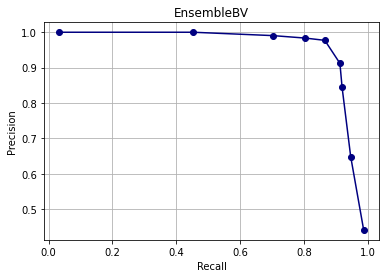

In [ ]:
accuracies = []
recalls = []
precisions = []
f1_score = []
for elem in treshold_test_result:
  accuracies.append(elem[0])
  recalls.append(elem[1])
  precisions.append(elem[2])
  f1_score.append(elem[3])
print('AP : ',mean(precisions))
# y_axis = plt.gca().yaxis
# x_axis = plt.gca().xaxis
# y_axis.set_major_formatter(PercentFormatter(1))
# x_axis.set_major_formatter(PercentFormatter(1))
plt.plot(recalls, precisions, 'o-', color='navy')
plt.title('Ensemble' + model_characteristics[0])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.grid(True)
plt.savefig(models_dir + '/Ensemble' + model_characteristics[0] +'.jpg')
plt.show()

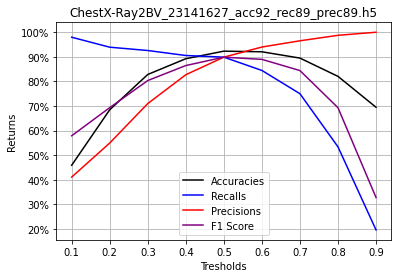

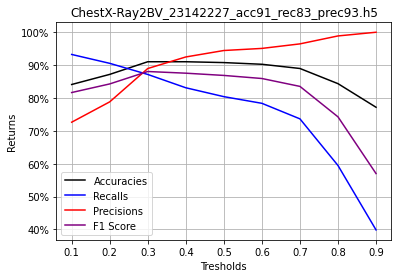

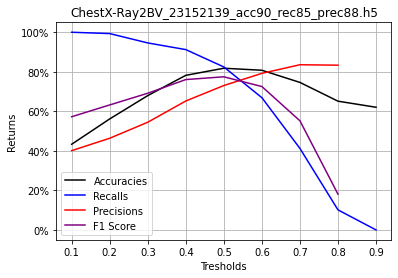

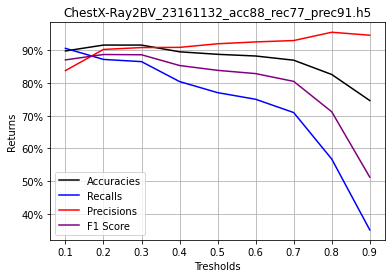

In [ ]:
#Ploting
tresholds = [.1*i for i in range(1,10)]

for treshold_test_result, tst_gen, model_dir in zip(treshold_test_results, tst_gens, model_dirs):
  accuracies = []
  recalls = []
  precisions = []
  f1_score = []
  img_dirs = []
  
  for elem in treshold_test_result:
    if len(tst_gen.class_indices) == 2:
      accuracies.append(elem[0])
      recalls.append(elem[1])
      precisions.append(elem[2])
      f1_score.append(elem[3])
    else:
      accuracies.append(mean(elem[0]))
      recalls.append(mean(elem[1]))
      precisions.append(mean(elem[2]))
      f1_score.append(mean(elem[3]))

  y_axis = plt.gca().yaxis
  y_axis.set_major_formatter(PercentFormatter(1))
  plt.plot(tresholds, accuracies, color='Black', label='Accuracies')
  plt.plot(tresholds, recalls, color='Blue', label='Recalls')
  plt.plot(tresholds, precisions, color='Red', label='Precisions')
  plt.plot(tresholds, f1_score, color='Purple', label='F1 Score')
  plt.title(model_dir.split('/')[-1])
  plt.ylabel('Returns')
  plt.xlabel('Tresholds')
  plt.legend()
  plt.grid(True)
  plt.savefig('{}.jpg'.format(model_dir.split('.')[0]))
  img_dirs.append('{}.jpg'.format(model_dir.split('.')[0]))
  plt.show()

In [ ]:
#Result Reporting
for model, model_dir, test_result, img_dir in zip(models, model_dirs, test_results, img_dirs):
  txt = model_dir.split('/')[-1] + ' tested :\n'
  for elem in model.metrics:
    txt += elem.name + ' = ' + '{:.2f}%\n'.format(100*test_result[model.metrics.index(elem)])
  txt += f'by {tester}.'
  LineNotify(tok, msg = txt, img_dir = img_dir)

In [ ]:
#Deleting Models (uncomment the following if RAM is not enough)
# del models
# K.clear_session()

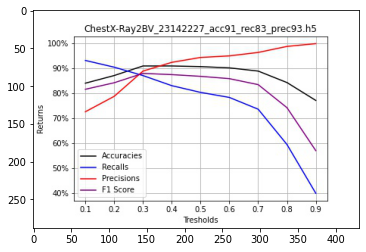

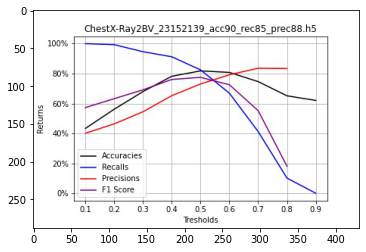

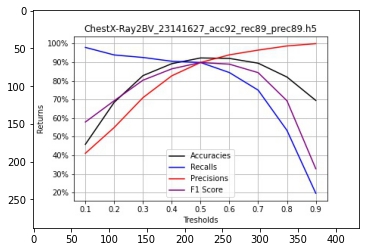

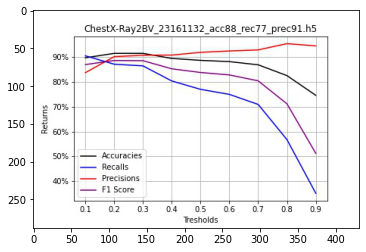

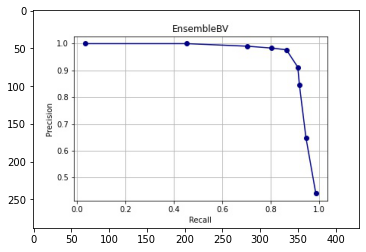


There're 5 pictures.



['/content/drive/MyDrive/chest_xray/ModelsToEnsembleBV/ChestX-Ray2BV_23142227_acc91_rec83_prec93.jpg',
 '/content/drive/MyDrive/chest_xray/ModelsToEnsembleBV/ChestX-Ray2BV_23152139_acc90_rec85_prec88.jpg',
 '/content/drive/MyDrive/chest_xray/ModelsToEnsembleBV/ChestX-Ray2BV_23141627_acc92_rec89_prec89.jpg',
 '/content/drive/MyDrive/chest_xray/ModelsToEnsembleBV/ChestX-Ray2BV_23161132_acc88_rec77_prec91.jpg',
 '/content/drive/MyDrive/chest_xray/ModelsToEnsembleBV/EnsembleBV.jpg']

In [ ]:
#Checking All Exported Pic. 
pic_dirs = glob(models_dir + '/*.jpg')
for pic_dir in pic_dirs:
  img = tf.keras.preprocessing.image.load_img(pic_dir)  # 讀取影像 將影像resize到網路輸入大小
  img = tf.keras.preprocessing.image.img_to_array(img) #將影像轉為array
  plt.imshow(img/255.)
  plt.show() 
print(f'\nThere\'re {len(pic_dirs)} pictures.\n' if len(pic_dirs)>1 else '\nThere\'s just a picture.\n')
pic_dirs